In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mahotas
from skimage.measure import shannon_entropy
import imgaug.augmenters as iaa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

Added features for Hemorrhagic: Haralick - [0.14783186745065874, 150.37191345755247, 0.9457002052996861, 1384.6309012454194, 0.5231075042027746, 73.68371050075433, 5388.151691524127, 5.3567411665430384, 7.582770629412727, 0.0008602092309127656, 3.3807931468320653, -0.3774115413606841, 0.9848679278749335], Entropy - 4.655101162561693
Added features for Hemorrhagic: Haralick - [0.22308933459862962, 158.00742408935807, 0.98244955050379, 4500.706528437164, 0.5593981283566777, 112.08773133036462, 17844.818689659303, 5.461483778620125, 7.620267022035213, 0.0010438458621882733, 3.3433490847320804, -0.4437352866151859, 0.9933562984324006], Entropy - 4.873885543487109
Added features for Hemorrhagic: Haralick - [0.027620894915150802, 366.67900773056465, 0.9701077219645143, 6135.501068674538, 0.3359208757790362, 197.40873995081324, 24175.325266967586, 7.218862914868173, 10.459869172748668, 0.0003663653614181583, 4.399398642033402, -0.35364900566815405, 0.9941628811254586], Entropy - 6.33865179247

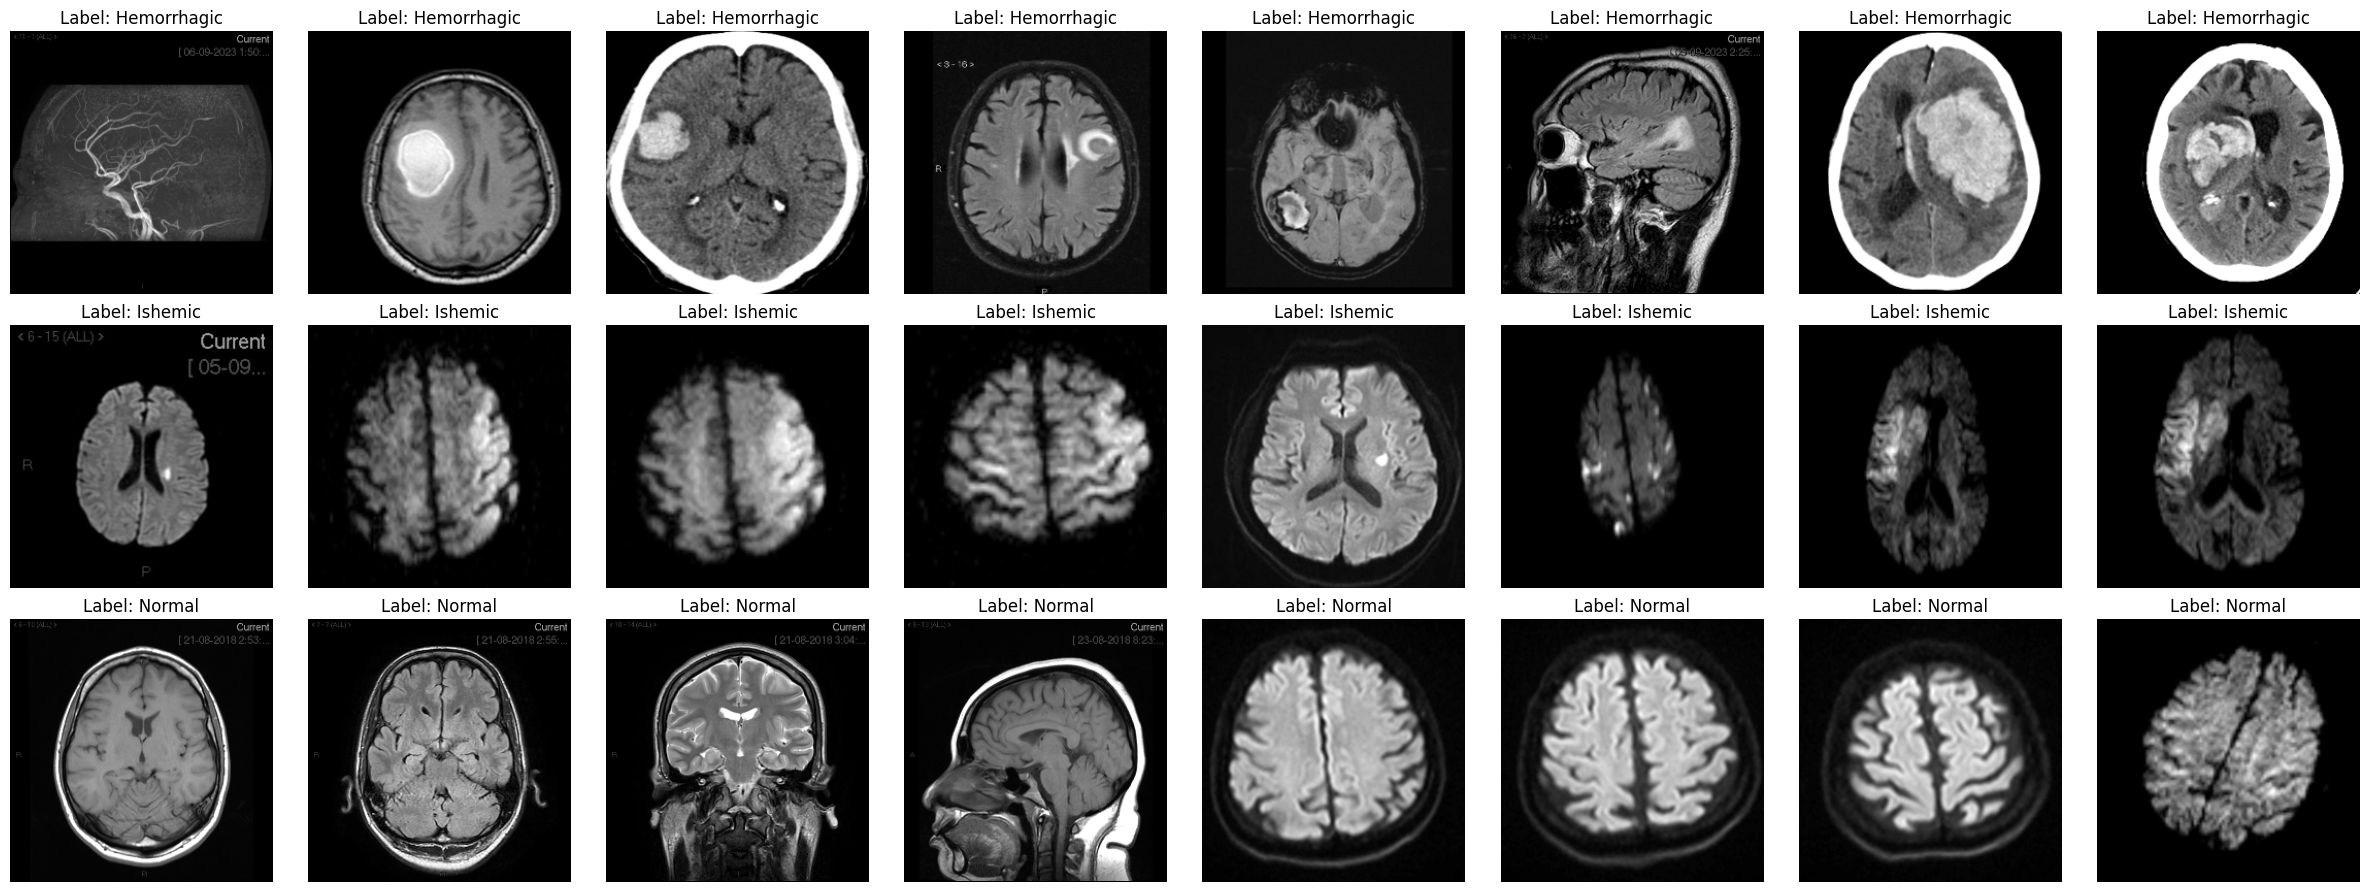

Label: Hemorrhagic, Haralick: [0.14783186745065874, 150.37191345755247, 0.9457002052996861, 1384.6309012454194, 0.5231075042027746, 73.68371050075433, 5388.151691524127, 5.3567411665430384, 7.582770629412727, 0.0008602092309127656, 3.3807931468320653, -0.3774115413606841, 0.9848679278749335], Entropy: 4.66
Label: Ishemic, Haralick: [0.42773028721292333, 153.03305658179949, 0.9648363354829873, 2175.2502367452153, 0.7219702122212442, 53.62978747330044, 8547.967890399063, 3.51182464071229, 4.794661725510122, 0.0018103485844613203, 2.375811891557191, -0.4290359717747316, 0.962403192213281], Entropy: 3.04
Label: Normal, Haralick: [0.04873605851775503, 459.8092647028433, 0.9465146619913771, 4297.804672015429, 0.5086917853411207, 110.56701417128326, 16731.40942335887, 6.396009869288437, 8.71604480038025, 0.0007661351446033735, 3.697418047742089, -0.42401886560317903, 0.9951823878195523], Entropy: 5.52


In [20]:
# Normalize image
def normalize_image(img):
    return img / 255.0

# Function to resize images
def preprocess_image(image_path, target_size=(255, 255)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    img_resized = cv2.resize(img, target_size)  # Resize image
    return img_resized

# Define a sequence of augmentation techniques
augmenters = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    iaa.Affine(rotate=(-20, 20)),  # Random rotations between -20 and 20 degrees
    iaa.Affine(scale=(0.8, 1.2)),  # Random zoom in and out
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Add Gaussian noise
    iaa.Crop(percent=(0, 0.1))  # Randomly crop images
])

# Function for data augmentation
def augment_image(image):
    image_aug = augmenters(image=image)
    return image_aug

# Function for feature extraction
def extract_features(image):
    # Calculate Haralick features
    haralick_features = mahotas.features.haralick(image.astype(np.uint8)).mean(axis=0)
    
    # Calculate entropy
    entropy = shannon_entropy(image)
    
    return {
        'haralick': haralick_features.tolist(),  # Convert to list
        'entropy': entropy
    }

# Directory paths
directories = {
    "Hemorrhagic": "Hemorrhagic",
    "Ishemic": "Ishemic",
    "Normal": "Normal"
}

# Load and preprocess the dataset
def load_dataset(directories):
    images = []
    labels = []
    image_paths = []  # Store image paths
    features_list = []  # Initialize an empty list for features
    label_map = {"Hemorrhagic": 0, "Ishemic": 1, "Normal": 2}
    for label, directory in directories.items():
        for root, _, files in os.walk(directory):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.png'):
                    image_path = os.path.join(root, file)
                    img = preprocess_image(image_path)  # Preprocess image
                    images.append(img)  # Store image
                    labels.append(label_map[label])
                    image_paths.append(image_path)  # Store image path
                    
                    # Extract features if needed
                    features = extract_features(img)  # Extract features
                    features_list.append({'label': label, 'haralick': features['haralick'], 'entropy': features['entropy']})  # Store feature dictionary
                    
                    # Debug: Print the features being added
                    print(f"Added features for {label}: Haralick - {features['haralick']}, Entropy - {features['entropy']}")
                    
    return images, labels, image_paths, features_list  # Return image paths along with images, labels, and features

# Load and preprocess the dataset
images, labels, image_paths, features_list = load_dataset(directories)

# Display images and features for each folder
def display_images(images, labels, num_images_per_category=8):
    categories = ["Hemorrhagic", "Ishemic", "Normal"]
    fig, axes = plt.subplots(len(categories), num_images_per_category, figsize=(num_images_per_category * 3, len(categories) * 3))  # Create a figure with rows for each category and num_images columns
    
    img_count = {category: 0 for category in categories}
    for i, img in enumerate(images):
        label = list(directories.keys())[labels[i]]
        if img_count[label] < num_images_per_category:
            ax = axes[list(directories.keys()).index(label), img_count[label]]
            ax.imshow(img, cmap='gray')
            ax.set_title(f"Label: {label}")
            ax.axis('off')
            img_count[label] += 1
    
    plt.tight_layout()
    plt.show()

# Display the first few images with labels
display_images(images, labels)

# Display the first 5 features from each category
categories_displayed = set()
for feature in features_list:
    if feature['label'] not in categories_displayed:
        print(f"Label: {feature['label']}, Haralick: {feature['haralick']}, Entropy: {feature['entropy']:.2f}")
        categories_displayed.add(feature['label'])
        if len(categories_displayed) == 3:
            break

In [21]:

# Split the dataset
def split_dataset(images, labels):
    train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
    train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = split_dataset(images, labels)
input_shape = (255, 255, 1)  # Define input shape for grayscale images

# Resize images and add a channel dimension for grayscale images
train_images = np.array([np.expand_dims(img, axis=-1) for img in train_images])  # Resize train images
val_images = np.array([np.expand_dims(img, axis=-1) for img in val_images])  # Resize validation images
test_images = np.array([np.expand_dims(img, axis=-1) for img in test_images])  # Resize test images

# Normalize images
train_images = normalize_image(train_images)
val_images = normalize_image(val_images)
test_images = normalize_image(test_images)

# One-hot encode labels
train_labels = to_categorical(train_labels, num_classes=3)  # One-hot encode train labels
val_labels = to_categorical(val_labels, num_classes=3)  # One-hot encode validation labels
test_labels = to_categorical(test_labels, num_classes=3)  # One-hot encode test labels

# Build the model
def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    return model

model = build_cnn_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 20

history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=epochs,
    batch_size=batch_size
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/20
9/9 [==============================] - 27s 3s/step - loss: 1.1618 - accuracy: 0.3891 - val_loss: 1.0327 - val_accuracy: 0.5000
Epoch 2/20
9/9 [==============================] - 20s 2s/step - loss: 0.9759 - accuracy: 0.5709 - val_loss: 0.8721 - val_accuracy: 0.5326
Epoch 3/20
9/9 [==============================] - 20s 2s/step - loss: 0.7928 - accuracy: 0.6364 - val_loss: 0.6662 - val_accuracy: 0.7065
Epoch 4/20
9/9 [==============================] - 20s 2s/step - loss: 0.6109 - accuracy: 0.7564 - val_loss: 0.5754 - val_accuracy: 0.7500
Epoch 5/20
9/9 [==============================] - 20s 2s/step - loss: 0.4473 - accuracy: 0.7818 - val_loss: 0.6850 - val_accuracy: 0.6957
Epoch 6/20
9/9 [==============================] - 20s 2s/step - loss: 0.4514 - accuracy: 0.8182 - val_loss: 0.4871 - val_accuracy: 0.8478
Epoch 7/20
9/9 [==============================] - 20s 2s/step - loss: 0.3055 - accuracy: 0.8691 - val_loss: 0.6168 - val_accuracy: 0.7935
Epoch 8/20
9/9 [==================

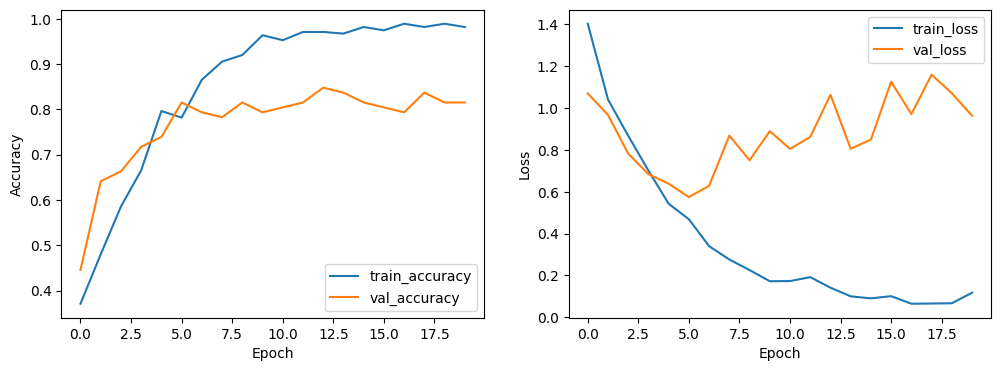

In [4]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

3/3 [==============================] - 1s 342ms/step


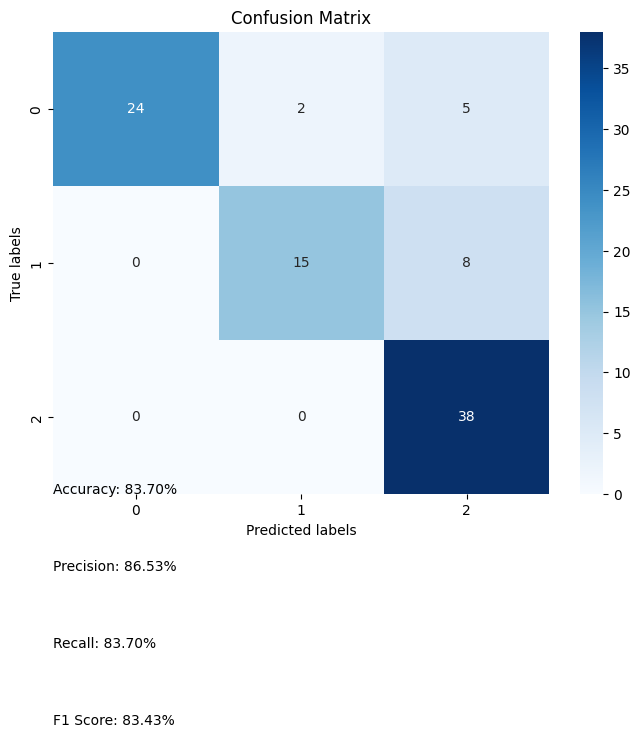

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Get the predicted labels for the test set
predicted_labels = model.predict(np.array(test_images))
predicted_labels = np.argmax(predicted_labels, axis=1)

# Convert one-hot encoded test labels back to categorical labels
true_labels = np.argmax(test_labels, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels) * 100
precision = precision_score(true_labels, predicted_labels, average='weighted') * 100
recall = recall_score(true_labels, predicted_labels, average='weighted') * 100
f1 = f1_score(true_labels, predicted_labels, average='weighted') * 100

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Add accuracy, precision, recall, and F1 score to plot
plt.text(0, 3, f'Accuracy: {accuracy:.2f}%', fontsize=10, ha='left')
plt.text(0, 3.5, f'Precision: {precision:.2f}%', fontsize=10, ha='left')
plt.text(0, 4, f'Recall: {recall:.2f}%', fontsize=10, ha='left')
plt.text(0, 4.5, f'F1 Score: {f1:.2f}%', fontsize=10, ha='left')

plt.show()


ROUGH CODES

Loading images from directory: Hemorrhagic
Loading images from directory: Ishemic
Loading images from directory: Normal


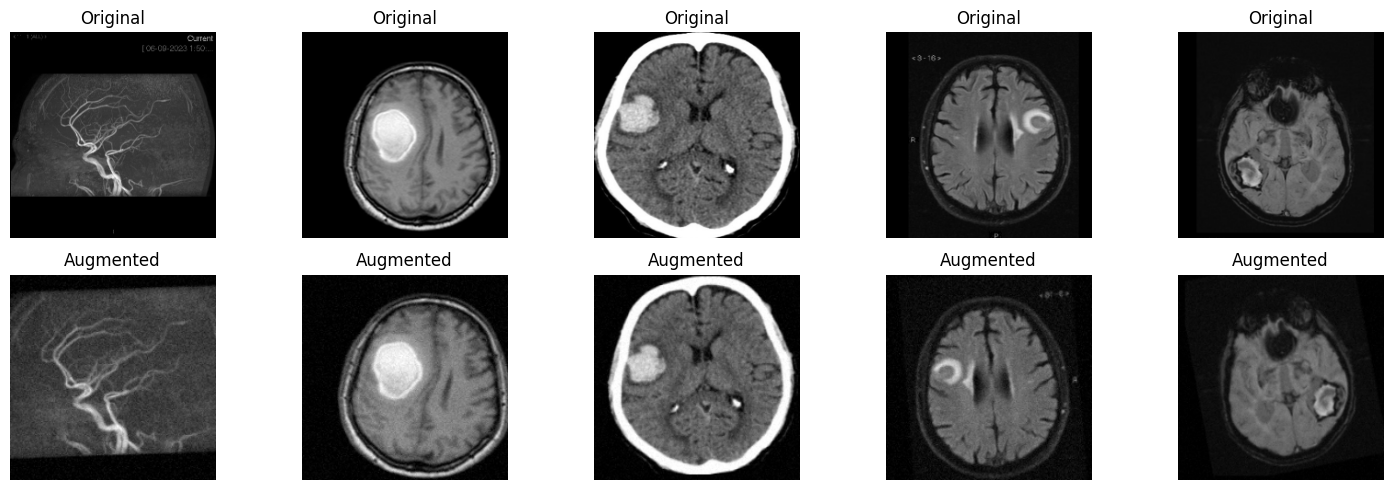

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

# Define a sequence of augmentation techniques
augmenters = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    iaa.Affine(rotate=(-20, 20)),  # Random rotations between -20 and 20 degrees
    iaa.Affine(scale=(0.8, 1.2)),  # Random zoom in and out
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Add Gaussian noise
    iaa.Crop(percent=(0, 0.1))  # Randomly crop images
])

# Function to resize images
def preprocess_image(image_path, target_size=(224, 224)):  
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    img_resized = cv2.resize(img, target_size)  # Resize image
    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)  # Convert grayscale image to RGB
    return img_resized

# Function to load images from a directory
def load_images(directory, num_images=5):
    images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                image_path = os.path.join(root, file)
                img = preprocess_image(image_path)
                if img is not None:
                    images.append(img)
                if len(images) >= num_images:
                    return images
    return images

# Function to display original and augmented images
def display_augmented_images(images, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))  # Create a figure with 2 rows and num_images columns
    for i in range(num_images):
        if i < len(images):
            original_img = images[i]
            augmented_img = augmenters(image=original_img)
            
            # Display original image
            axes[0, i].imshow(original_img)
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            
            # Display augmented image
            axes[1, i].imshow(augmented_img)
            axes[1, i].set_title('Augmented')
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load images from each category
directories = {
    "Hemorrhagic": "Hemorrhagic",
    "Ishemic": "Ishemic",
    "Normal": "Normal"
}

all_images = []
for label, directory in directories.items():
    print(f"Loading images from directory: {directory}")
    images = load_images(directory, num_images=5)
    all_images.extend(images)

# Display original and augmented images
display_augmented_images(all_images, num_images=5)


Loading images from directory: Hemorrhagic
Loading images from directory: Ishemic
Loading images from directory: Normal


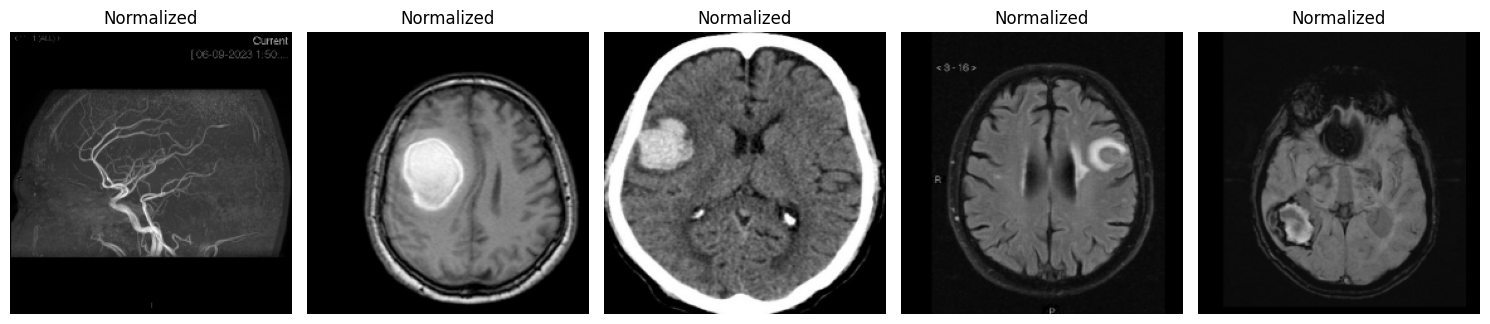

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to resize images
def preprocess_image(image_path, target_size=(224, 224)):  
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    img_resized = cv2.resize(img, target_size)  # Resize image
    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)  # Convert grayscale image to RGB
    return img_resized

# Function to normalize images
def normalize_image(img):
    return img / 255.0

# Function to load images from a directory
def load_images(directory, num_images=5):
    images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                image_path = os.path.join(root, file)
                img = preprocess_image(image_path)
                if img is not None:
                    images.append(img)
                if len(images) >= num_images:
                    return images
    return images

# Function to display normalized images
def display_normalized_images(images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Create a figure with 1 row and num_images columns
    for i in range(num_images):
        if i < len(images):
            normalized_img = normalize_image(images[i])
            
            # Display normalized image
            axes[i].imshow(normalized_img)
            axes[i].set_title('Normalized')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load images from each category
directories = {
    "Hemorrhagic": "Hemorrhagic",
    "Ishemic": "Ishemic",
    "Normal": "Normal"
}

all_images = []
for label, directory in directories.items():
    print(f"Loading images from directory: {directory}")
    images = load_images(directory, num_images=5)
    all_images.extend(images)

# Display normalized images
display_normalized_images(all_images, num_images=5)


Loading images from directory: Hemorrhagic
Loading images from directory: Ishemic
Loading images from directory: Normal


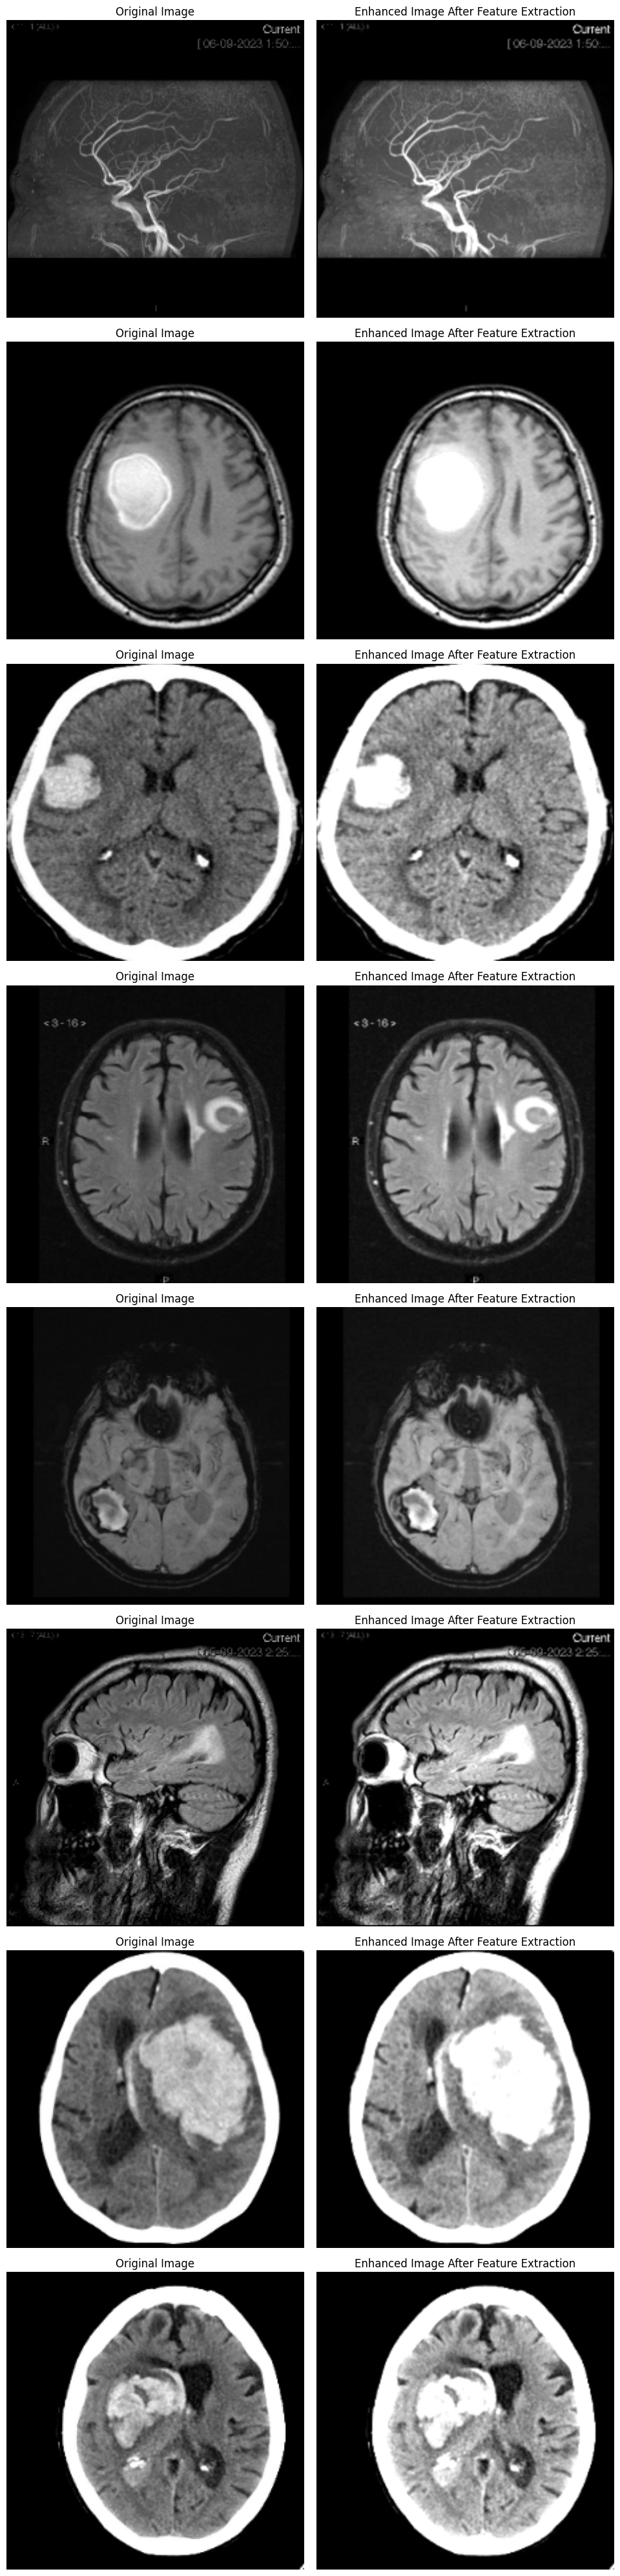

In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mahotas
from skimage.measure import shannon_entropy

# Function to resize images
def preprocess_image(image_path, target_size=(224, 224)):  
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    img_resized = cv2.resize(img, target_size)  # Resize image
    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)  # Convert grayscale image to RGB
    return img_resized

# Function to normalize images
def normalize_image(img):
    return img / 255.0

# Function for feature extraction
def extract_features(image):
    # Calculate Haralick features
    haralick_features = mahotas.features.haralick(image.astype(np.uint8)).mean(axis=0)
    
    # Calculate entropy
    entropy = shannon_entropy(image)
    
    return {
        'haralick': haralick_features,
        'entropy': entropy
    }

# Function to load images from a directory
def load_images(directory, num_images=8):
    images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                image_path = os.path.join(root, file)
                img = preprocess_image(image_path)
                if img is not None:
                    images.append(img)
                if len(images) >= num_images:
                    return images
    return images

# Function to enhance image after feature extraction
def enhance_image(image):
    # Increase contrast
    enhanced_img = cv2.convertScaleAbs(image, alpha=1.5, beta=0)
    # Resize to simulate cropping
    enhanced_img = cv2.resize(enhanced_img, (image.shape[1] * 2, image.shape[0] * 2))
    return enhanced_img

# Function to display images and their extracted features
def display_images_and_features(images, num_images=3):
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))  # Create a figure with num_images rows and 2 columns
    
    for i in range(num_images):
        if i < len(images):
            original_img = images[i]
            normalized_img = normalize_image(original_img)
            normalized_img_uint8 = (normalized_img * 255).astype(np.uint8)
            
            # Enhance image after feature extraction
            enhanced_img = enhance_image(normalized_img_uint8)
            
            # Display original image
            axes[i, 0].imshow(original_img)
            axes[i, 0].set_title('Original Image')
            axes[i, 0].axis('off')
            
            # Display enhanced image
            axes[i, 1].imshow(enhanced_img)
            axes[i, 1].set_title('Enhanced Image After Feature Extraction')
            axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load images from each category
directories = {
    "Hemorrhagic": "Hemorrhagic",
    "Ishemic": "Ishemic",
    "Normal": "Normal"
}

all_images = []
for label, directory in directories.items():
    print(f"Loading images from directory: {directory}")
    images = load_images(directory, num_images=8)
    all_images.extend(images)

# Display images and features
display_images_and_features(all_images, num_images=8)
